## Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from tinnsleep.config import Config
from tinnsleep.reports import preprocess, reporting, generate_bruxism_report
from tinnsleep.utils import merge_labels_list
print("config loaded")


config loaded


In [2]:
#Setting parameters
EDF_list = Config.bruxisme_files
results_file = "data/reports_and_datas_bruxism.pk"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [3]:
# change to --overwrite True if you want to force to recompute the results
%run ../compute_results.py --bruxism True --overwrite False 


config loaded
Performs Bruxism: <True>
Performs MEMA: <False>
Will overwrite existing results: <False>
parameters set
result files exist: Reports creation skipped.


# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [4]:
results = pd.read_pickle(results_file).to_dict()
THR_classif = results[list(results.keys())[0]]["THR_classif"]

## Data visualization for the entire cohort for nb episodes per hour as a function of THR_classif value : 

Text(0, 0.5, 'Nb of episodes per hour')

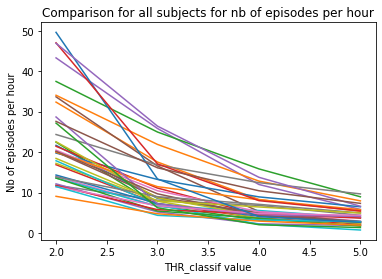

In [5]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Number of episodes per hour"])
    st = elm.split(os.path.sep)[-1] + " len " + str(ep["Clean data duration"])
    plt.plot([i+2 for i in range(len(THR_classif))], nb_ep)
plt.title('Comparison for all subjects for nb of episodes per hour')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')


## Data visualization for the entire cohort for nb bursts as a function of THR_classif value : 

Text(0, 0.5, 'Nb of burst on the recording')

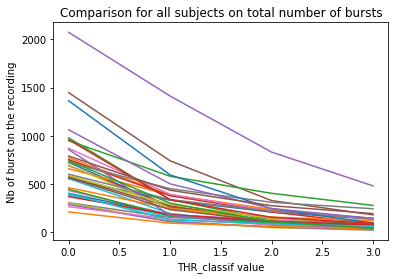

In [6]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Total number of burst"])
    #print(f"Number of bursts for each THR_classif for {elm[-19:]} : {nb_ep}")
    st = elm.split(os.path.sep)[-1] + " len " + str(ep["Clean data duration"])
    plt.plot(nb_ep)
plt.title('Comparison for all subjects on total number of bursts')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of burst on the recording')

## Logs of the preprocessing : 

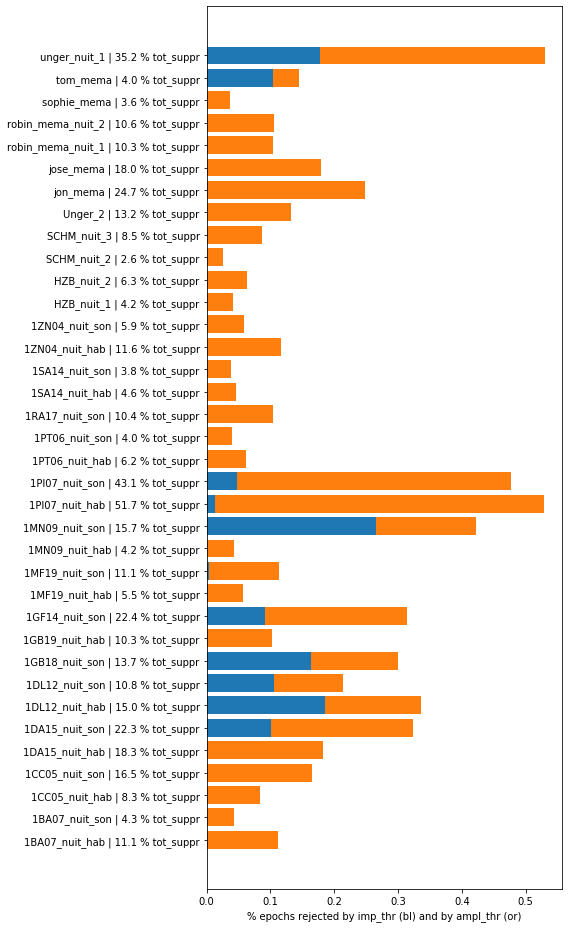

In [7]:
file=[]
suppr_imp=[]
suppr_amp=[]
for elm in results.keys():
    if results[elm]["log"]["Bruxism"]['suppressed_overall']/results[elm]["log"]["Bruxism"]['total_nb_epochs'] > 0.0001:
        file.append(elm.split(os.path.sep)[-1][:-4] + " | " + 
                    str("%.1f" % (100 *results[elm]["log"]["Bruxism"]['suppressed_overall']/results[elm]["log"]["Bruxism"]['total_nb_epochs']))
                   + " % tot_suppr")
        suppr_imp.append((results[elm]["log"]["IMP"]['suppressed_overall']/results[elm]["log"]["IMP"]['total_nb_epochs']))
        suppr_amp.append(results[elm]["log"]["Bruxism"]['suppressed_overall']/results[elm]["log"]["Bruxism"]['total_nb_epochs'])
       


fig, ax = plt.subplots(figsize=(8, 13))
rect1 = ax.barh(file, suppr_imp)
rect2 = ax.barh(file, suppr_amp, left=suppr_imp)
plt.xlabel("% epochs rejected by imp_thr (bl) and by ampl_thr (or)")
plt.tight_layout()
plt.show()


## Extracting list of nb of episodes per hour for all THR_classif per patient

In [8]:
get_scores=[]
for elm in results.keys():
        #print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            l_ep_h.append(ep["Number of episodes per hour"])

        get_scores.append([elm.split(os.path.sep)[-1], l_ep_h])
print(len(get_scores))
print(get_scores[-3:])

36
[['sophie_mema.edf', [47.02194357366771, 17.11241617396135, 8.035395420816634, 5.505733899448435]], ['tom_mema.edf', [46.90670777010169, 26.447399061865845, 13.805874981980285, 6.6534337262555585]], ['unger_nuit_1.edf', [27.62065741886137, 16.147461260257415, 10.48168537946534, 7.365508645029698]]]


## Getting masking, VAS-Loudness and  VAS-Intrusiveness data

In [9]:
get_masking = pd.read_csv("data/evol_masquage.csv", delimiter=";")
#print(get_masking)
get_VAS_L = pd.read_csv("data/evol_eva_I.csv", delimiter=";")
#print(get_VAS_L)
get_VAS_I = pd.read_csv("data/evol_eva_G.csv", delimiter=";")
#print(get_VAS_I)

evol_masking = get_masking.values.tolist()[:-4]
evol_VAS_L = get_VAS_L.values.tolist()
evol_VAS_I = get_VAS_I.values.tolist()



## Comparing nb_ep/hour between patients with tinnitus increase (augm) and without (stable) for values of THR_classif

Nb_patients in each group : 
Tinnitus increase : 13
Tinnitus stable : 16


Text(0, 0.5, 'Nb of episodes per hour')

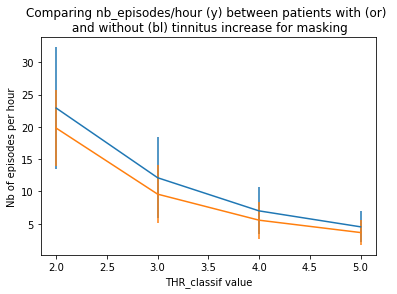

In [10]:
# Files not to consider for analysis
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_masking:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for masking" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for absolute overnight evolutions of tinnitus

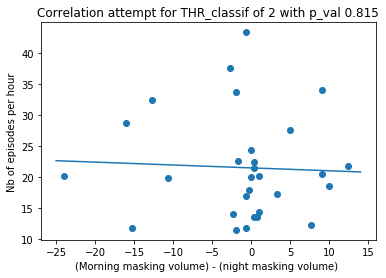

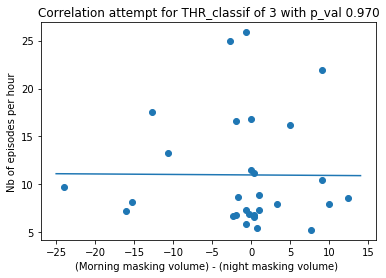

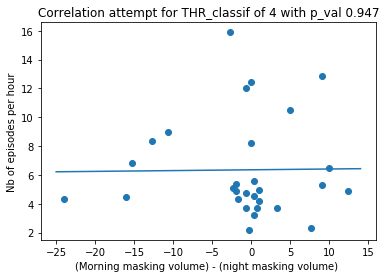

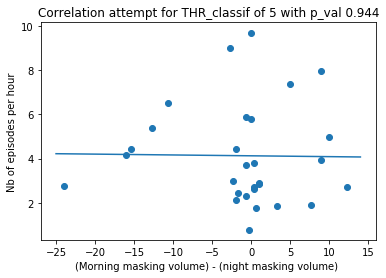

In [11]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-25 for i in range(40)],[intercept + slope *(i-25) for i in range(40)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for percentage overnight evolutions of tinnitus

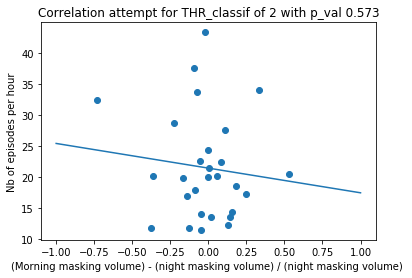

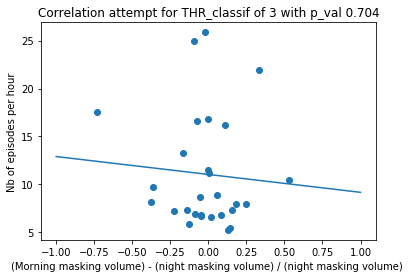

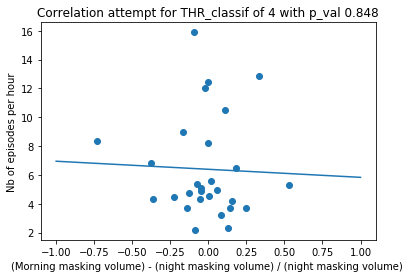

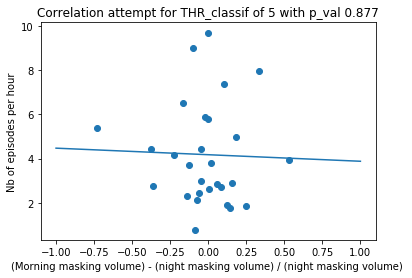

In [12]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) / (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## VAS-L

Nb_patients in each group : 
Tinnitus increase : 6
Tinnitus stable : 24


Text(0, 0.5, 'Nb of episodes per hour')

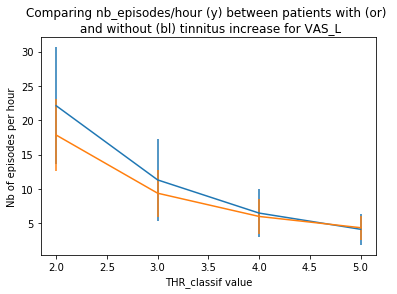

In [13]:
# Files not to consider for analysis
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_VAS_L:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS_L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

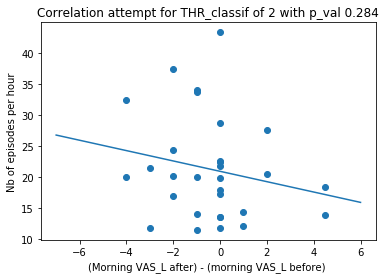

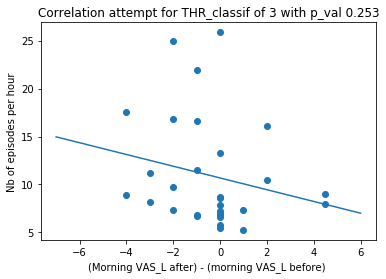

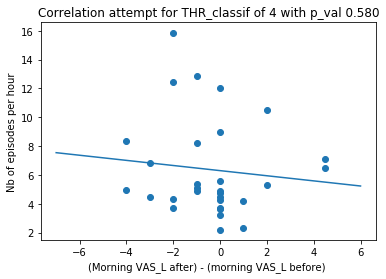

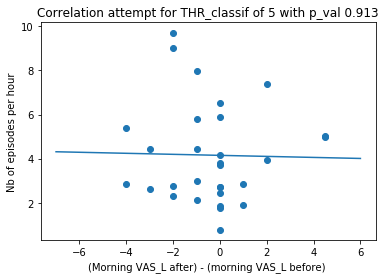

In [14]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

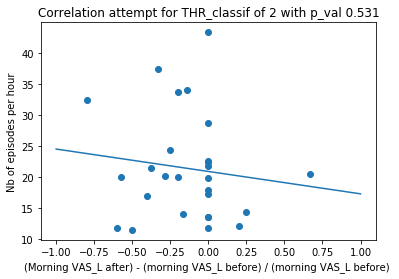

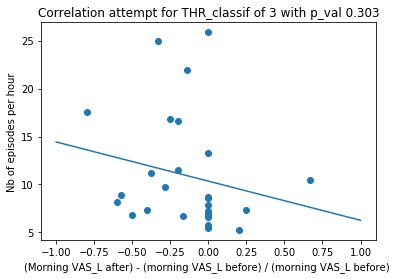

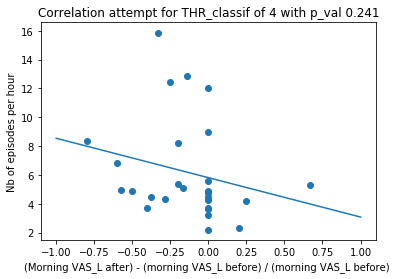

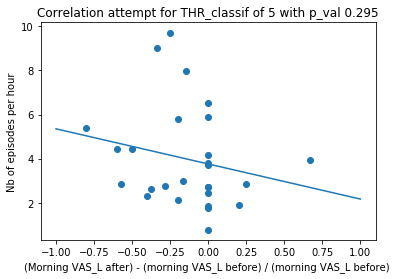

In [15]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) / (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

## VAS_I

Nb_patients in each group : 
Tinnitus increase : 7
Tinnitus stable : 23


Text(0, 0.5, 'Nb of episodes per hour')

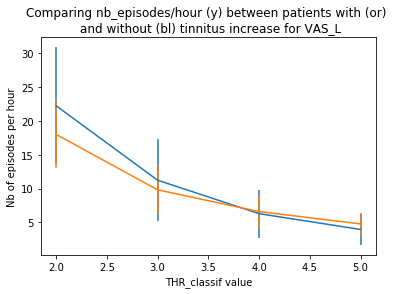

In [16]:
# Files not to consider for analysis
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_VAS_I:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS_L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

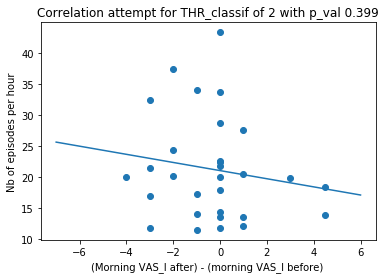

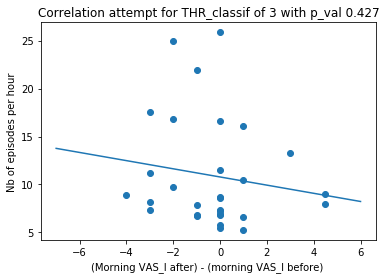

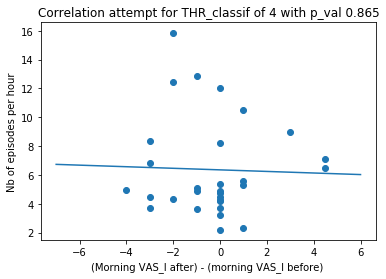

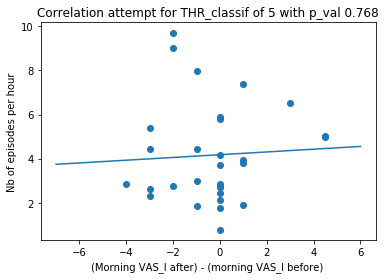

In [17]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')

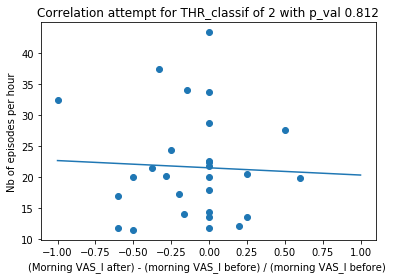

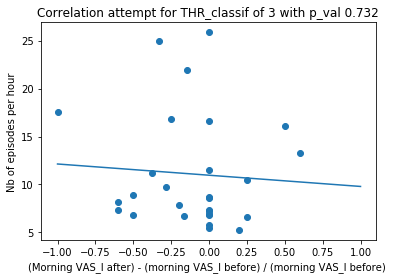

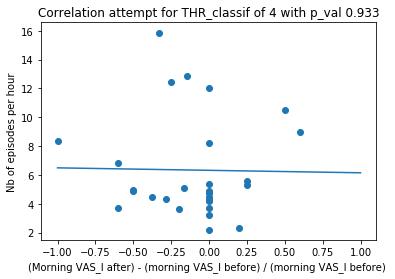

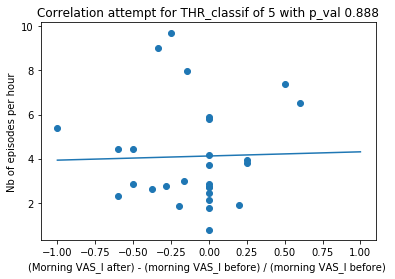

In [18]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) / (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')